<a href="https://colab.research.google.com/github/Kryptera-K/ALLE-Multi-Layer-Breakout-Reversion-Strategy/blob/main/ALLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "ALLE"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("ALLE_clean.csv", index=False)
df

/tmp/ipython-input-2918362361.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2013-11-18,42.765022,44.105840,41.891729,43.885311,587100
2013-11-19,40.400967,43.223742,39.959908,43.214923,1682000
2013-11-20,39.386513,40.577369,38.804316,40.559726,1106900
2013-11-21,38.627907,39.827587,37.966319,39.254209,730200
2013-11-22,38.804317,38.901347,38.151550,38.724927,947600
...,...,...,...,...,...
2025-11-14,161.250000,164.139999,160.470001,163.330002,888600
2025-11-17,159.970001,161.580002,159.380005,161.580002,752600
2025-11-18,161.070007,161.440002,158.729996,159.949997,1043500


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
KC_MULTIPLIER = 2
KC_PERIOD = 20
KC_SHIFT = 5
MOMENTUM_LEVEL = 100
MOMENTUM_PERIOD = 10
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def momentum_cross_below_level(df, level=MOMENTUM_LEVEL, period=MOMENTUM_PERIOD):
    df = calculate_momentum(df, period)
    return (df["Momentum"] < level) & (df["Momentum"].shift(1) >= level)


def calculate_momentum(df, period=MOMENTUM_PERIOD):
    """
    Classic momentum: current close / close n periods ago * 100
    """
    df = df.copy()
    df["Momentum"] = df["Close"] / df["Close"].shift(period) * 100
    return df


def kc_open_above_lower(df):
    df = calculate_keltner_channel(df)
    return df['Open'] > df['KC_Lower']


def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    """
    Calculate Keltner Channel (Mid, Upper, Lower) and ATR.
    """
    df = df.copy()

    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # EMA of Typical Price
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    # True Range and ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Upper and Lower Bands
    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def kumo_breakout_bullish(df):
    df = calculate_ichimoku(df)
    return df['Close'] > df[['senkou_span_a', 'senkou_span_b']].max(axis=1)


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def wr_lower_than_level(df, level=WR_LEVEL):
    df = calculate_williams_r(df)
    return df['Williams_%R'] < level


def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Momentum_Cross_Below_Level"] = momentum_cross_below_level(df)
df["KC_Open_Above_Lower"] = kc_open_above_lower(df)

# -------------------------
# Exit conditions
# -------------------------

df["Ichimoku_Kumo_Breakout_Bullish"] = kumo_breakout_bullish(df)
df["WR_is_Lower_Than_Level"] = wr_lower_than_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Momentum_Cross_Below_Level',
    'KC_Open_Above_Lower',
]
exit_conditions = [
    'Ichimoku_Kumo_Breakout_Bullish',
    'WR_is_Lower_Than_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                         2013-11-18 00:00:00
End                           2025-11-20 00:00:00
Period                         3021 days 00:00:00
Start Value                              100000.0
End Value                            530307.60752
Total Return [%]                       430.307608
Benchmark Return [%]                   269.212374
Max Gross Exposure [%]                      100.0
Total Fees Paid                      27301.120583
Max Drawdown [%]                        34.383038
Max Drawdown Duration           576 days 00:00:00
Total Trades                                   51
Total Closed Trades                            50
Total Open Trades                               1
Open Trade PnL                      -49913.668849
Win Rate [%]                                 64.0
Best Trade [%]                          26.451708
Worst Trade [%]                        -16.598474
Avg Winning Trade [%]                    7.443823
Avg Losing Trade [%]                    -2.534792


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2013-11-18 00:00:00
End                           2025-11-20 00:00:00
Period                         3021 days 00:00:00
Start Value                              100000.0
End Value                           369212.374257
Total Return [%]                       269.212374
Benchmark Return [%]                   269.212374
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        41.199002
Max Drawdown Duration           727 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      269212.374257
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-450688825.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


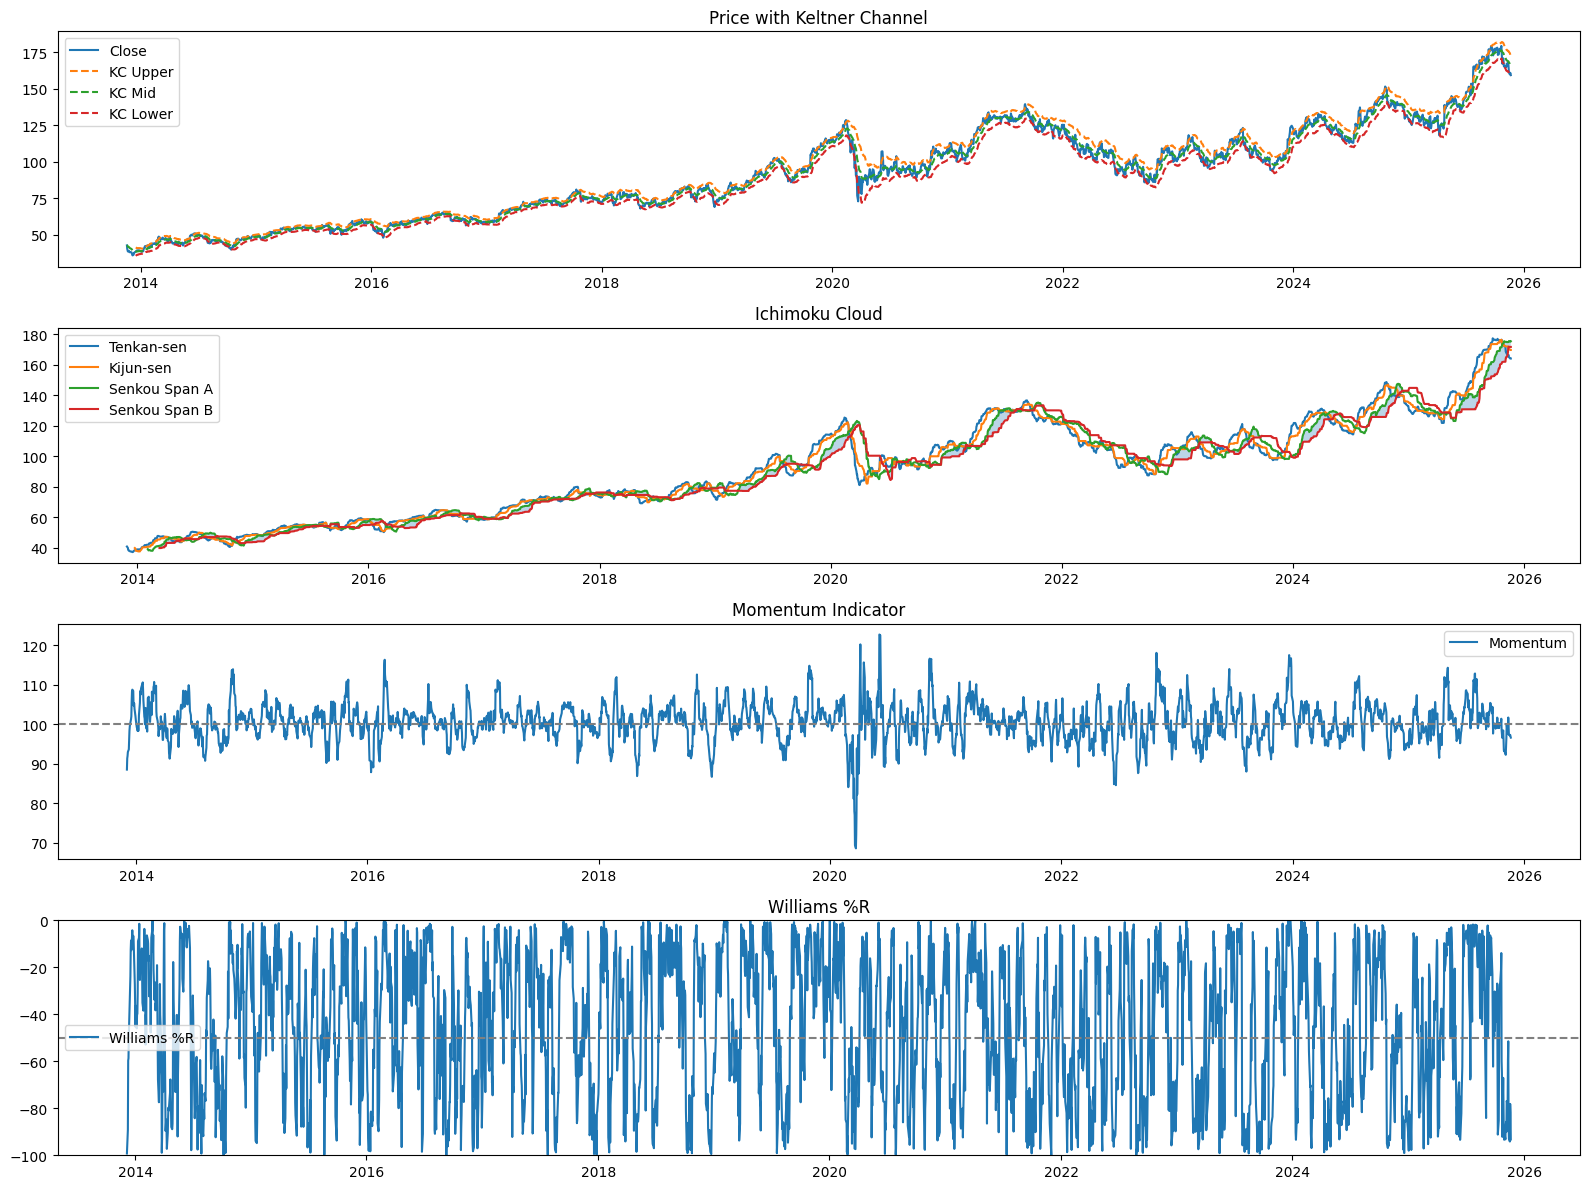

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "ALLE"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Indicator Functions
# -------------------------

def calculate_momentum(df, period=10):
    df = df.copy()
    df["Momentum"] = df["Close"] / df["Close"].shift(period) * 100
    return df

def calculate_keltner_channel(df, period=20, multiplier=2):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)

    df['ATR'] = df['TR'].rolling(period).mean()

    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']
    return df

def calculate_ichimoku(df, tenkan_period=9, kijun_period=26, senkou_b_period=52, displacement=26):
    df = df.copy()

    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() +
                        df['Low'].rolling(tenkan_period).min()) / 2

    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() +
                       df['Low'].rolling(kijun_period).min()) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)

    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() +
                            df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)

    df['chikou_span'] = df['Close'].shift(-displacement)

    return df

def calculate_williams_r(df, period=14):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df

# -------------------------
# Calculate All Indicators
# -------------------------

df = calculate_momentum(df)
df = calculate_keltner_channel(df)
df = calculate_ichimoku(df)
df = calculate_williams_r(df)

# -------------------------
# Plotting
# -------------------------

plt.figure(figsize=(16, 12))

# === 1. Price + Keltner Channel ===
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['KC_Upper'], label='KC Upper', linestyle='--')
plt.plot(df.index, df['KC_Mid'], label='KC Mid', linestyle='--')
plt.plot(df.index, df['KC_Lower'], label='KC Lower', linestyle='--')
plt.title("Price with Keltner Channel")
plt.legend()

# === 2. Ichimoku Cloud ===
plt.subplot(4, 1, 2)
plt.plot(df.index, df['tenkan_sen'], label='Tenkan-sen')
plt.plot(df.index, df['kijun_sen'], label='Kijun-sen')
plt.plot(df.index, df['senkou_span_a'], label='Senkou Span A')
plt.plot(df.index, df['senkou_span_b'], label='Senkou Span B')
plt.fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                 where=df['senkou_span_a'] >= df['senkou_span_b'],
                 alpha=0.3)
plt.title("Ichimoku Cloud")
plt.legend()

# === 3. Momentum ===
plt.subplot(4, 1, 3)
plt.plot(df.index, df['Momentum'], label='Momentum')
plt.axhline(100, color='gray', linestyle='--')
plt.title("Momentum Indicator")
plt.legend()

# === 4. Williams %R ===
plt.subplot(4, 1, 4)
plt.plot(df.index, df['Williams_%R'], label='Williams %R')
plt.axhline(-50, color='gray', linestyle='--')
plt.ylim(-100, 0)
plt.title("Williams %R")
plt.legend()

plt.tight_layout()
plt.show()
